In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape : (None, 4, 4, 768)


In [6]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [8]:
X = np.load('data/X.npy')
Y = np.load('data/Y.npy')

print(X.shape, Y.shape)

(1643, 100, 100, 3) (1643, 2)


C:\Users\LeHaMinhTrung\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


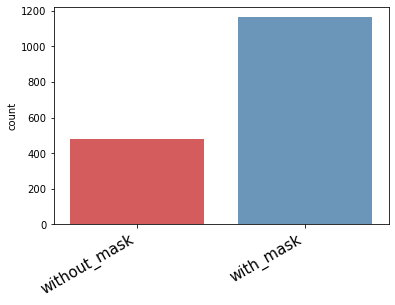

In [9]:
ax = sns.countplot(np.argmax(Y, axis=1), palette="Set1", alpha=0.8)
ax.set_xticklabels(['without_mask', 'with_mask'], rotation=30, ha="right", fontsize=15)
plt.show()

In [10]:
X = X / 255.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/model-{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True, 
    verbose=0)

history = model.fit(X_train, 
                    Y_train, 
                    epochs=20, 
                    callbacks=[checkpoint], 
                    validation_split=0.1)

Epoch 1/20
42/42 [==============================] - 17s 294ms/step - loss: 0.3845 - acc: 0.9556 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/20
42/42 [==============================] - 11s 267ms/step - loss: 0.0297 - acc: 0.9992 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/20
42/42 [==============================] - 10s 246ms/step - loss: 0.0132 - acc: 0.9992 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/20
42/42 [==============================] - 10s 231ms/step - loss: 0.0104 - acc: 0.9977 - val_loss: 5.4772e-08 - val_acc: 1.0000
Epoch 5/20
42/42 [==============================] - 9s 216ms/step - loss: 2.1594e-04 - acc: 1.0000 - val_loss: 5.6704e-07 - val_acc: 1.0000
Epoch 6/20
42/42 [==============================] - 9s 216ms/step - loss: 1.8852e-05 - acc: 1.0000 - val_loss: 3.5441e-08 - val_acc: 1.0000
Epoch 7/20
42/42 [==============================] - 9s 226ms/step - loss: 5.8868e-04 - acc: 0.9992 - val_loss: 1.8371e-06 - val_acc: 1.0000
Epoch 8/20
42/42 [==============

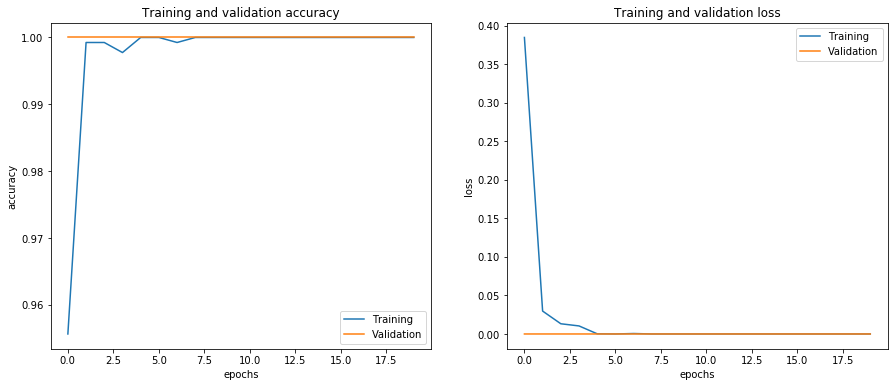

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
model.save('data/inceptionV3-model.h5')

In [15]:
model.evaluate(X_test, Y_test)

6/6 [==============================] - 1s 163ms/step - loss: 6.2302e-04 - acc: 1.0000


[0.0006230247090570629, 1.0]

In [16]:
Y_pred = np.argmax(model.predict(X_test), axis=1)

In [17]:
Y_test = np.argmax(Y_test, axis=1)

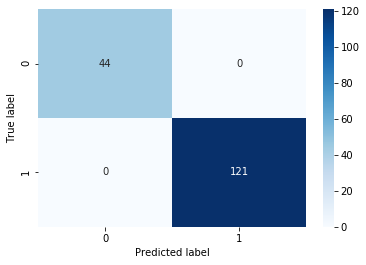

In [18]:
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()